In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import time
import datetime
from queue import Queue
from collections import deque
from scipy.stats import norm
from itertools import accumulate
import numpy.polynomial.polynomial as poly
from scipy.integrate import quad 

from utils import parse_date,determine_R0,return_polyfit,decay_to_max,unwrap_projections,unwrap_daily_projections
from generators import advanced_projector,infection_projector,daily_projector

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
group = np.array([1,2,2,5])
uniques,counts = np.lib.arraysetops.unique(group,return_counts=True)
print(uniques,counts)

[1 2 5] [1 2 1]


In [13]:
r = [0,1,2,3,4]
raw_data = {'greenBars': [20, 1.5, 7, 10, 5], 'orangeBars': [5, 15, 5, 10, 15],'blueBars': [2, 15, 18, 5, 10]}
df = pd.DataFrame(raw_data)
 
# From raw value to percentage
totals = [i+j+k for i,j,k in zip(df['greenBars'], df['orangeBars'], df['blueBars'])]
greenBars = [i / j * 100 for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * 100 for i,j in zip(df['orangeBars'], totals)]
blueBars = [i / j * 100 for i,j in zip(df['blueBars'], totals)]
# print(totals,greenBars,orangeBars)
# plot
# barWidth = 0.85
# names = ('A','B','C','D','E')
# # Create green Bars
# plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# # Create orange Bars
# plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
# # Create blue Bars
# plt.bar(r, blueBars, bottom=[i+j for i,j in zip(greenBars, orangeBars)], color='#a3acff', edgecolor='white', width=barWidth)
 
# # Custom x axis
# plt.xticks(r, names)
# plt.xlabel("group")
 
# # Show graphic
# plt.show()


[27.0, 31.5, 30.0, 25.0, 30.0] [74.07407407407408, 4.761904761904762, 23.333333333333332, 40.0, 16.666666666666664] [18.51851851851852, 47.61904761904761, 16.666666666666664, 40.0, 50.0]


# Plotting functions

In [2]:
def plot_totals(cases,deaths=None):
    epochs = range(1,len(cases)+1)
    _, ax = plt.subplots()
    ax.plot(epochs,cases,'g',label="Confirmed Cases")
    if deaths:
        ax.plot(epochs,deaths,'m',label="Deaths")
    ax.set_title('Covid19')
    ax.set_xlabel('Days')
    ax.set_ylabel('Cases')
    ax.legend()
    plt.show()
    # plt.savefig('assets/Covid19',bbox_inches='tight')
    # plt.close()
    
def detailed_plot(values,labels,show=False):
    colors = ['b','g','r','c','m','y','lightblue','lightgreen','gray','teal']
    for i,label in enumerate(labels):
        epochs = range(1,len(values[label])+1)
        plt.plot(epochs,values[label],colors[i],label=f"{label}")
        plt.title('Covid19')
        plt.xlabel('Days')
        plt.ylabel('Cases')
        plt.legend()
    if show:
        plt.show()

# Data paths

Data gathered by download_datasets.sh

In [3]:
general_path = 'novel-corona-virus-2019-dataset'
korea_path = 'coronavirusdataset'
USA_path = 'covid19-in-usa'
Italy_path = 'covid19-in-italy'
coronavirusapi_States_path = 'states.csv'
coronavirusapi_USA_path = 'time_series.csv'
covidtracking_States_path = 'states_daily.csv'
covidtracking_USA_path = 'us_daily.csv'

In [4]:
korea_timeline = os.path.join(korea_path,'Time.csv')
general_timeline = os.path.join(general_path,'time_series_covid_19_confirmed.csv')
USA_1 = os.path.join(USA_path,'us_covid19_daily.csv')
USA_2 = os.path.join(USA_path,'us_states_covid19_daily.csv')
italy_file = os.path.join(Italy_path,'covid19_italy_region.csv')
italy_file2 = os.path.join(Italy_path,'covid19_italy_province.csv')

In [5]:
korea_df = pd.read_csv(korea_timeline)
general_df = pd.read_csv(general_timeline)
USA_1df = pd.read_csv(USA_1)
USA_2df = pd.read_csv(USA_2)
italy_df = pd.read_csv(italy_file)
italy_df2 = pd.read_csv(italy_file2)
coronavirusapi_States_df = pd.read_csv(coronavirusapi_States_path)
coronavirusapi_USA_df = pd.read_csv(coronavirusapi_USA_path)
covidtracking_States_df = pd.read_csv(covidtracking_States_path)
covidtracking_USA_df = pd.read_csv(covidtracking_USA_path)
USA_testing_df = pd.read_csv(coronavirusapi_USA_path)

In [6]:
Italy = general_df[general_df['Country/Region'] == 'Italy']
US = general_df[general_df['Country/Region'] == 'US']

In [7]:
covidtracking_USA_df.tail()

,date,states,positive,negative,posNeg,pending,hospitalized,death,total
15,20200319,56,11723,89119,100842,3025,NaN,160.0,103867
16,20200320,56,17038,118147,135185,3336,NaN,219.0,138521
17,20200321,56,23203,155909,179112,3477,1964.0,322.0,182589
18,20200322,56,31888,193463,225351,2842,2554.0,398.0,228216
19,20200323,56,42164,237321,279485,14571,2664.0,471.0,294056


# Extend testing data

In [8]:
unique_dates = USA_testing_df['date'].unique()
tests_preformed = []
tests_positive = []
for date in unique_dates:
    rows = USA_testing_df[USA_testing_df['date'] == date]
    tests_preformed.append(rows['tested'].values[-1])
    tests_positive.append(rows['positive'].values[-1])
data_dict = {'dates':unique_dates,'tested':tests_preformed,'positive': tests_positive}
df_us_tests = pd.DataFrame.from_dict(data_dict)
df_us_tests['ratio'] = df_us_tests['positive'] / df_us_tests['tested']
print(df_us_tests['ratio'].mean())

0.14289994297181863


In [9]:
X1 = 5
Y1 = np.gradient(df_us_tests['tested'].values)[X1]
X2 = 13
Y2 = np.gradient(df_us_tests['tested'].values)[X2]
points = [(X1,Y1),(X2,Y2)]
degree = 3

print(f'X1,Y1 {X1,Y1}')
print(f'X2,Y2 {X2,Y2}')
test_base,A_factor = determine_R0(points)

X1,Y1 (5, 4751.0)
X2,Y2 (13, 37256.0)


last_point 134959.42569438403 new_point 142479.71284719202


/Users/morgan/Code/Covid19/utils.py:37: RankWarning: The fit may be poorly conditioned
  coefs = poly.polyfit(x, y, degree)


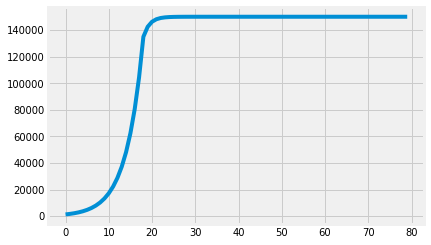

In [10]:
line,coefs = return_polyfit(np.array([X1,X2]),np.array([Y1,Y2]),degree)
max_daily_tests = 150*1e+3
Ys = np.power(test_base,np.arange(19))*A_factor
end_ys = decay_to_max(max_daily_tests,Ys[-1],61)

projected_tests = np.concatenate([Ys,end_ys])
plt.plot(projected_tests)

# USA projections

In [269]:
def continuous_R0(initial_population,R0,days):
    '''
    returns cases on a per asymptomatic_period
    '''
    return np.power(R0,days) * initial_population
    
def generate_active_cases(params):
    population,R0,asymptomatic_period,inflection_point,base_R0,traveler_cases,down_cycles = params.values()
    active_cases = continuous_R0(population,R0,np.linspace(0,inflection_point,inflection_point*asymptomatic_period))
    down_start = inflection_point*asymptomatic_period
    down_end = (down_cycles*asymptomatic_period)
    down_cases = np.zeros(down_end)
    active_cases = np.concatenate([active_cases,down_cases])
    day = 1 / asymptomatic_period
    for i in range(down_start,down_end+down_start):
        active_cases[i] = continuous_R0(active_cases[i-1],R0,day)
        R0 += (base_R0 - R0) / 2
        R0 = max(R0,base_R0)
    return active_cases

def integrate(R0,initial_population,asymptomatic_period,xmin,xmax):
    def func(x):
        return np.power(R0,x) * initial_population
    res, err = quad(func, xmin, xmax) 
    print ('norm: ', res,err)
    
def general_integration(points,bins):
    indexes = np.linspace(0,len(points),bins)
    for i,index in enumerate(indexes):
        
    

# def integrate(active_cases,asymptomatic_period):
#     total_cases = np.zeros(len(active_cases))
#     total_cases[0] = active_cases[0]
#     for i in range(1,len(active_cases)):
#         total_cases[i] = active_cases[i] - active_cases[i-1]
#     return total_cases

def generate_hospitalizations(active_cases,hospitalization_rate,hospital_days):
    hospitalized_patients = deque(maxlen=hospital_days)
    hospitalizations = np.zeros(len(active_cases))
    for i,cases in enumerate(active_cases):
        hospitalized_patients.append(cases * hospitalization_rate)
        hospitalizations[i] = sum(hospitalized_patients)
    return hospitalizations

## Initial assumptions

In [265]:
population = 1
R0 = 2.3
asymptomatic_period = 5
inflection_point = 10 # of cycles since to Jan 24 to March 16
R0_reduction = 0.9
base_R0 = 0.90
daily_traveler_cases = 50
pos_rate = 0.14
hospital_days = 14
hospitalization_rate = 0.05

daily_params = {
        'population':population,
        'R0':R0,
        'asymptomatic_period':asymptomatic_period,
        'inflection_point':inflection_point,
        'base_R0':base_R0,
        'traveler_cases':daily_traveler_cases,
        'down_cycles':20
         }

In [271]:
t = np.array([1.00000000e+00, 1.18528287e+00, 1.40489548e+00, 1.66519854e+00,
       1.97373130e+00, 2.33942990e+00])
integrate(R0,population,asymptomatic_period,0,50)

norm:  1.4648534623191457e+18 112180.26611328125


# Generate predictions

In [246]:
active_cases = generate_active_cases(daily_params)
total_cases = integrate(active_cases,asymptomatic_period)
hospitalizations = generate_hospitalizations(active_cases,hospitalization_rate,hospital_days)
daily_hospitalizations = np.gradient(hospitalizations)
projected_values = [active_cases,total_cases,daily_hospitalizations,hospitalizations,np.gradient(projected_tests),projected_tests]
projection_labels = ('active_cases','total_cases','daily_hospitalizations','hospitalizations','daily_tests','total_tests')


In [247]:

projection_combined = {projection_labels[i]:projected_values[i] for i in range(len(projection_labels))}

In [248]:
projection_combined['active_cases']

array([1.00000000e+00, 1.18528287e+00, 1.40489548e+00, 1.66519854e+00,
       1.97373130e+00, 2.33942990e+00, 2.77288619e+00, 3.28665449e+00,
       3.89561526e+00, 4.61740603e+00, 5.47293227e+00, 6.48697286e+00,
       7.68889780e+00, 9.11351884e+00, 1.08020977e+01, 1.28035414e+01,
       1.51758183e+01, 1.79876374e+01, 2.13204385e+01, 2.52707505e+01,
       2.99529876e+01, 3.55027631e+01, 4.20808169e+01, 4.98776713e+01,
       5.91191493e+01, 7.00729149e+01, 8.30562256e+01, 9.84451213e+01,
       1.16685316e+02, 1.38305106e+02, 1.63930673e+02, 1.94304218e+02,
       2.30305461e+02, 2.72977117e+02, 3.23555100e+02, 3.83504317e+02,
       4.54561097e+02, 5.38783481e+02, 6.38610830e+02, 7.56934476e+02,
       8.97181467e+02, 1.06341382e+03, 1.26044619e+03, 1.49398527e+03,
       1.77079515e+03, 2.09889315e+03, 2.48778210e+03, 2.94872550e+03,
       3.49507382e+03, 4.14265112e+03, 4.89354884e+03, 5.37585968e+03,
       5.62121151e+03, 5.70310831e+03, 5.68877871e+03, 5.62328938e+03,
      

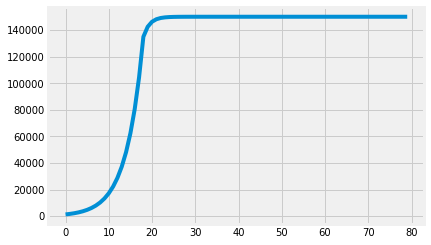

In [242]:
plt.plot(projection_combined['total_tests'])

# Interpolate between 5 day increments for projected values

In [ ]:
# def interpolate_projections(projections):
#     degree = 2
#     length = 3
#     day_interval = 5
#     interpolated = []
#     for i in range(len(projections)-length):
#         x = np.arange(i,i+length)
#         y = projections[i:i+length]
#         line,coefs = return_polyfit(x,y,degree)
#         days = np.linspace(i,i+length,day_interval*length)
# #         print(days)
#         new_ys = poly.polyval(days, coefs)
#         if i == len(projections)-4:
#             interpolated.append(new_ys)
#         else:
#             interpolated.append(new_ys[:5])
#     return np.hstack(interpolated)
    
# def fill_in_projections(projections,labels):
#     for label in labels:
#         projections[label] = interpolate_projections(projections[label])
#     return projections

In [ ]:

# R0_mask = np.where(np.array(projection_combined['R0']) < 2.3)[0]
# end_index = np.min(R0_mask)
# R0_part1 = np.full(end_index*5,2.3)
# R0_part2 = interpolate_projections(projection_combined['R0'][end_index:])
# new_R0 = np.concatenate([R0_part1,R0_part2])
# projection_combined['R0'] = new_R0

In [ ]:
# interpolate_labels = ['current_infections','total_infections','hospitalized_patients','daily_confirmed','total_confirmed','daily_tests','total_tests']
# projection_combined = fill_in_projections(projection_combined,interpolate_labels)
# projection_combined['day'] = np.arange(projection_combined['total_infections'].shape[0])

In [ ]:

# keys = projection_combined.keys()
# for key in keys:
#     print(projection_combined[key].shape)

In [ ]:
# plt.plot(projection_combined['current_infections'])

In [ ]:
# covidtracking_USA_df['date']

# US values

In [ ]:
padding = np.full(44,0)

In [ ]:
US_positive = np.concatenate([padding,covidtracking_USA_df['positive']])
US_negative = np.concatenate([padding,covidtracking_USA_df['negative']])
US_tests = np.concatenate([padding,covidtracking_USA_df['posNeg']])
US_hospitalized = np.concatenate([padding,covidtracking_USA_df['hospitalized']])
US_deaths = np.concatenate([padding,covidtracking_USA_df['death']])

In [ ]:
US_cases = US.iloc[:,4:]
US_totals = US_cases.sum(axis=0).values

In [ ]:
US_actual_start = datetime.datetime(2020,1,20)
data_start_date = datetime.datetime(2020,3,4)
print(f'Duration since first case {datetime.datetime.now() - US_actual_start}')
print(f'Duration from first case to data start {data_start_date - US_actual_start}')

In [ ]:
US_deaths.shape[0]

# Plot real values vs projected

In [ ]:
values = [np.gradient(US_positive),US_positive
          ,np.gradient(US_negative),US_negative,
          np.gradient(US_tests),US_tests,
          np.gradient(US_hospitalized),US_hospitalized,
          np.gradient(US_deaths),US_deaths]
labels = ['daily_confirmed','total_confirmed',
          'daily_negative','total_negative',
          'daily_tests','total_tests',
          'daily_hospitalizations','total_hospitalizations',
          'daily_deaths','total_deaths']
us_combined = {labels[i]:values[i] for i in range(len(values))}
desired_labels = ['daily_confirmed','daily_tests','daily_hospitalizations']

In [ ]:
detailed_plot(projection_combined,desired_projection_labels)

detailed_plot(us_combined,desired_labels)

In [ ]:
plt.plot(np.gradient(US_positive),label='daily US positive')
plt.plot(projection_combined['daily_confirmed'],label='projected daily confirmed')
plt.plot(projection_combined['current_infections'],label='projected infected')
plt.plot(projection_combined['daily_tests'],label='projected daily tests')
plt.legend()

In [ ]:
plt.plot(us_combined['daily_hospitalizations'],label='US daily hospitalizations')
plt.plot(projection_combined['hospitalized_patients'],label='projected hospitalizations')
plt.legend()

In [ ]:
plt.plot(us_combined['daily_tests'],label='US tests')
plt.plot(projection_combined['daily_tests'],label='projected tests')
plt.legend()

In [ ]:
values = [US_positive,US_negative,US_tests,US_hospitalized,US_deaths]
labels = ['Positive','Negative','Tests','Hospitalizations','Deaths']
detailed_plot(values,labels)

# Italy

In [ ]:
italy_cases = Italy.iloc[:,4:]
italy_totals = italy_cases.values[0]

In [ ]:
plot_totals(italy_totals)

In [ ]:
plot_totals(np.gradient(italy_totals))

In [ ]:
peak_italy_index = np.argmax(np.gradient(italy_totals))
print(f'Peak index {peak_italy_index}')
print(f'Confirmed cases {italy_totals[peak_italy_index]}')

italy_first_case_index = np.min(np.nonzero(italy_totals))
italy_start_date = parse_date(Italy.columns[4+italy_first_case_index])
italy_peak_date = parse_date(Italy.columns[4+peak_italy_index])
print(f'Date of first case {italy_start_date}')
print(f'Date of peak {italy_peak_date}')

print(f'Duration until peak {italy_peak_date - italy_start_date}')
print(f'Duration since first case {datetime.datetime.now() - italy_start_date}')